In [12]:
import warnings
warnings.filterwarnings('ignore')

import time
import os
from datetime import date

print(time.ctime())
path = os.path.abspath('')
print(path)
today = date.today().strftime('%d.%m.%Y')

Fri Jul  7 09:49:00 2023
/Users/khatran/Library/CloudStorage/OneDrive-TrườngĐạihọcPhenikaa/Quantum Computing/GitHub/GRAPE/GRAPE-for-qubit/experiments/x01_gate_lagos


In [13]:
from qiskit.tools.jupyter import *
from qiskit import pulse
from qiskit.circuit import Parameter, QuantumCircuit, Gate
from qiskit import schedule
from qiskit.tools.monitor import job_monitor
from qiskit import IBMQ

import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

In [14]:
if not IBMQ.active_account():
    IBMQ.load_account()

provider = IBMQ.get_provider(hub='ibm-q')

In [15]:
backend = provider.get_backend('ibm_lagos')
backend_config = backend.configuration()
dt = backend_config.dt
print(f"Sampling time: {dt*1e9} ns.")
acquire_alignment = backend_config.timing_constraints['acquire_alignment']
granularity = backend_config.timing_constraints['granularity']
pulse_alignment = backend_config.timing_constraints['pulse_alignment']

lcm = np.lcm(acquire_alignment, pulse_alignment)
print(f"Least common multiple of acquire_alignment and pulse_alignment: {lcm}.")
backend_defaults = backend.defaults()

Sampling time: 0.2222222222222222 ns.
Least common multiple of acquire_alignment and pulse_alignment: 16.


In [16]:
GHz = 1.0e9
MHz = 1.0e6
us = 1.0e-6
ns = 1.0e-9
ps = 1.0e-12

qubit = 0

N = 64
T = N * dt #ns

In [17]:
def get_closest_multiple_of(vaule, base_number):
    return int(vaule + base_number/2) - (int(vaule + base_number/2) % base_number)

def get_closest_multiple_of_16(num):
    return get_closest_multiple_of(num, granularity)

def get_dt_from(sec):
    return get_closest_multiple_of(sec/dt, lcm)

def fit_function(x_values, y_values, function, init_params):
    fitparams, conv = curve_fit(function, x_values, y_values, init_params)
    y_fit = function(x_values, *fitparams)

In [18]:
from qiskit.pulse import library
from qiskit.pulse import Waveform
import math

In [19]:
import h5py

result = []

with h5py.File('/Users/khatran/Library/CloudStorage/OneDrive-TrườngĐạihọcPhenikaa/Quantum Computing/GitHub/GRAPE/GRAPE-for-qubit/output/x01_π/00020_x01_lagos.h5', 'r') as hf:
    data = hf.get('uks')
    result = data[...]

print(result.shape)    

(5, 1, 1, 144)


In [21]:
data = result[4][0][0]
print(data.shape)

(144,)


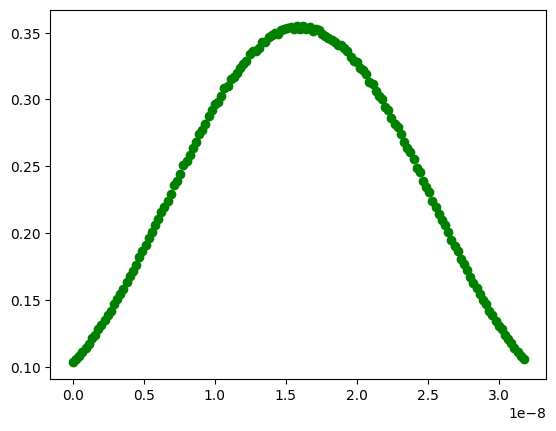

In [22]:
import matplotlib.pyplot as plt
%matplotlib inline

N = len(data)
T = dt * N
ops_max_amp = [2 * np.pi * 0.073036776]
Hnames = 'x'
plt.scatter(np.array([dt * ii for ii in range(len(data))]), np.array(data), color='green', marker='o', label='u' + Hnames + '0')

In [23]:
defaults = backend.defaults()
freq_Hz = defaults.qubit_freq_est[qubit]
freq_GHz = freq_Hz / GHz
print(freq_GHz)

5.23535192562653


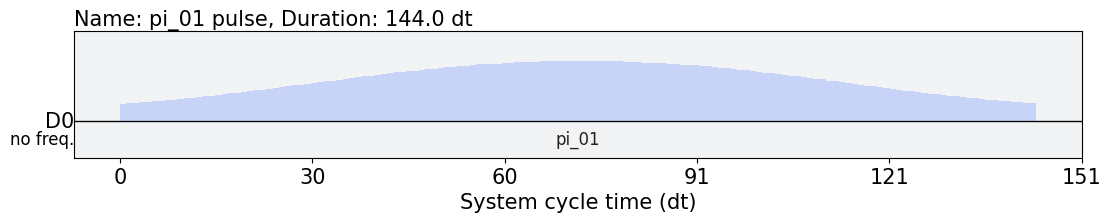

In [24]:
with pulse.build(backend, name='pi_01 pulse') as pi01_pulse:
    pulse_amp = Waveform(data, name='pi_01')
    dur = len(data)
    d0 = pulse.DriveChannel(0)
    # pulse.set_frequency(freq_GHz, d0)
    pulse.play(pulse_amp, d0)

pi01_pulse.draw()

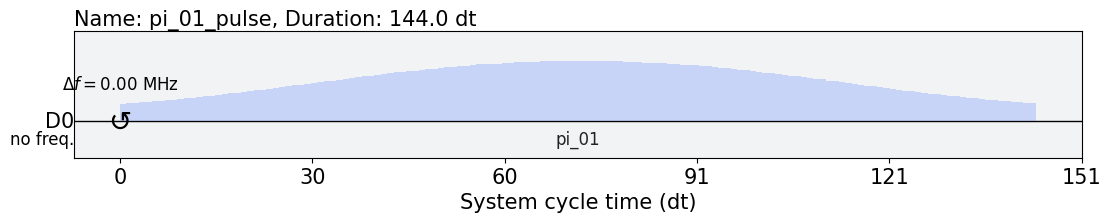

In [25]:
with pulse.build(backend=backend, default_alignment='sequential', name='pi_01_pulse') as pi01_schedule:
    d0 = pulse.DriveChannel(0)
    pulse.set_frequency(freq_GHz, d0)
    pulse.call(pi01_pulse)

pi01_schedule.draw() 

In [26]:
q0 = QuantumCircuit(1,1)
q0.measure(0,0)

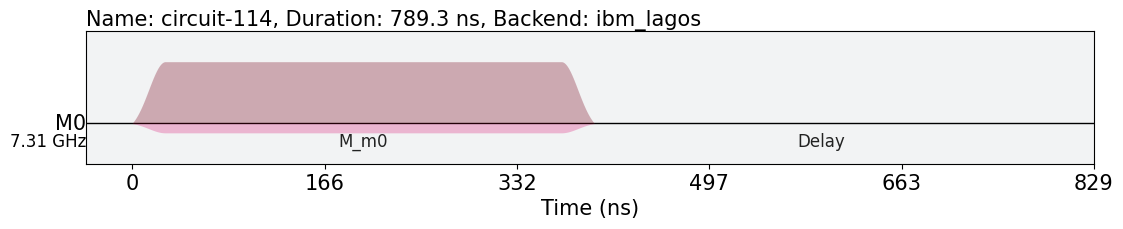

In [27]:
g0_schedule = schedule(q0, backend)
g0_schedule.draw(backend=backend)

In [28]:
q1 = QuantumCircuit(1,1)
q1.x(0)
# q1.add_calibration('x', (0,), pi01_pulse, [])

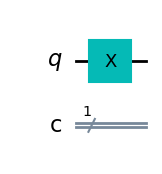

In [29]:
q1.draw(output='mpl')

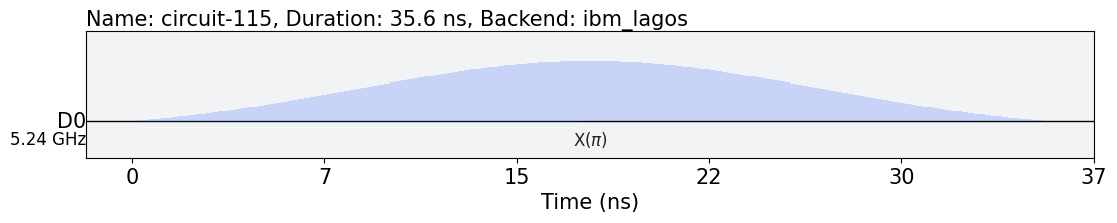

In [30]:
from qiskit import schedule

g1_schedule = schedule(q1, backend)
g1_schedule.draw(backend=backend)

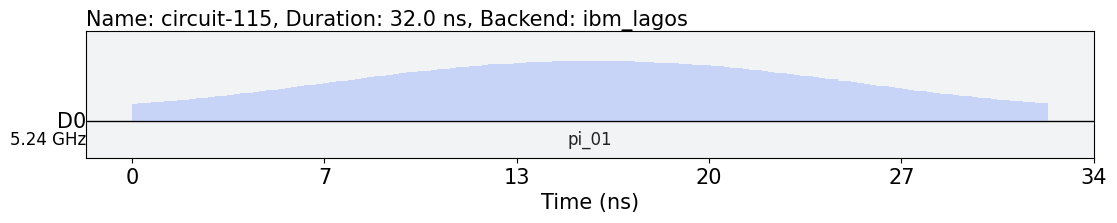

In [31]:
q1.add_calibration('x', (0,), pi01_pulse, [])
g1_schedule = schedule(q1, backend)
g1_schedule.draw(backend=backend)

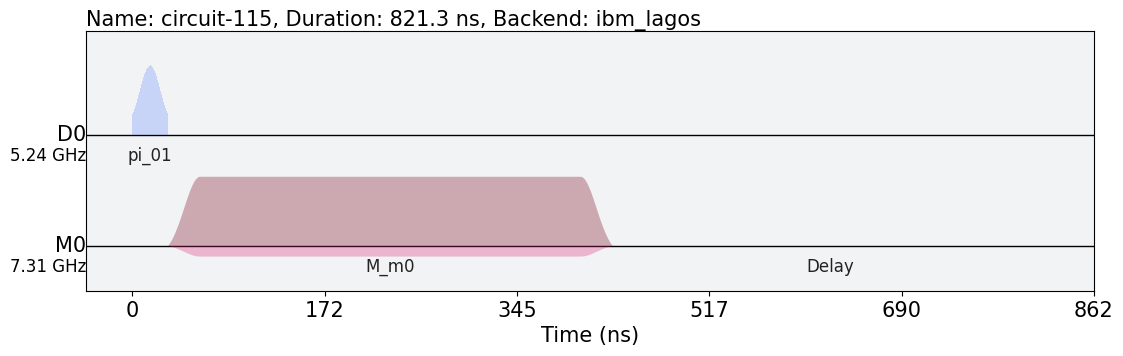

In [32]:
q1.measure(0,0)
exec_schedule = schedule(q1, backend)
exec_schedule.draw(backend=backend)

In [33]:
num_shots = 2048

job = backend.run([q0, q1],
                  meas_level=1,
                  meas_return='single',
                  shots=num_shots)

In [34]:
print(job.job_id())

cijns5st4v6egats0u70


In [14]:
from qiskit_ibm_runtime import QiskitRuntimeService
service = QiskitRuntimeService()

In [15]:
service.jobs()

[<RuntimeJob('cii4ggr5n9v6ta1r8uag', 'circuit-runner')>,
 <RuntimeJob('cihp28c60l54kvbltpa0', 'circuit-runner')>,
 <RuntimeJob('cih97vep0prapshevfs0', 'circuit-runner')>,
 <RuntimeJob('cigovn7985671v4v6fdg', 'circuit-runner')>,
 <RuntimeJob('cigo8p35n9v6ta0fvf50', 'circuit-runner')>,
 <RuntimeJob('cif8kqru5mrpmcc0k6og', 'circuit-runner')>,
 <RuntimeJob('ciepjdup0prapsngiup0', 'circuit-runner')>,
 <RuntimeJob('chm7ka37ca17j369mueg', 'qasm3-runner')>,
 <RuntimeJob('chm2llj7ca17j3663vd0', 'qasm3-runner')>,
 <RuntimeJob('chlqvrb7ca17j3616hag', 'circuit-runner')>]

In [8]:
job = backend.retrieve_job(job_id='cij3vvv985671v74r8n0')

In [9]:
result = job.result(timeout=120)

In [10]:
scale_factor = 1e-7
s0_results = result.get_memory(0)[:,qubit] * scale_factor
s1_results = result.get_memory(1)[:,qubit] * scale_factor

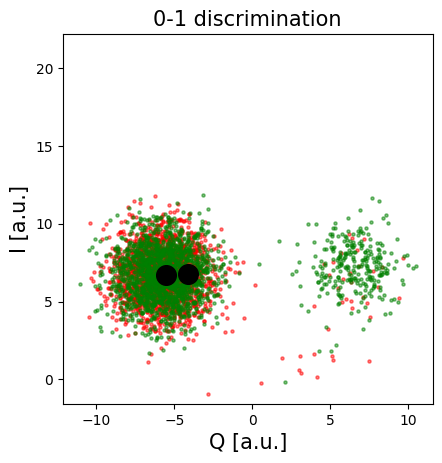

In [11]:
plt.figure()
plt.scatter(np.real(s0_results), np.imag(s0_results), s=5, cmap='viridis', c='red', alpha=0.5, label='state_0')
plt.scatter(np.real(s1_results), np.imag(s1_results), s=5, cmap='viridis', c='green', alpha=0.5, label='state_1')
plt.axis('square')

mean_gnd = np.mean(s0_results)
mean_exc = np.mean(s1_results)

plt.scatter(np.real(mean_gnd), np.imag(mean_gnd), s=200, cmap='viridis', c='black',alpha=1.0, label='state_0_mean')
plt.scatter(np.real(mean_exc), np.imag(mean_exc), s=200, cmap='viridis', c='black',alpha=1.0, label='state_1_mean')
plt.ylabel('I [a.u.]', fontsize=15)
plt.xlabel('Q [a.u.]', fontsize=15)
plt.title("0-1 discrimination", fontsize=15)
plt.show()

In [ ]:
import math

def classify(point: complex):
    def distance(a, b):
        return math.sqrt((np.real(a) - np.real(b))**2 + (np.imag(a) - np.imag(b))**2)
    return int(distance(point, mean_exc) < distance(point, mean_gnd))